# Prática 2: análise e representação de dados coletados por flutuadores Deep BCG Argo

Hoje você manipulará dados de temperatura, salinidade e oxigênio coletados por flutuadores biogeoquímicos Deep Argo no Atlântico. Trabalhar com esses dados requer aprender um pouco sobre arquivos netCDF. É importante não se distrair com a complexidade do conjunto de dados. Trabalhar com arquivos netCDF e perfis Argo se tornará muito mais fácil quando aprendermos sobre xarray em duas semanas. Por enquanto, no entanto, vamos focar nas ferramentas que já aprendemos.

Instruções:

Crie os melhores gráficos possíveis, prestando atenção especial a rótulos, unidades, mapas de cores, etc.
Salve as suas figuras em formato .png.
Descreva os resultados: o que você vê?
Discuta os resultados: o que explica as diferenças entre os perfis?
Se você estiver confortável com loops "for", tente usar o mínimo possível de código repetitivo.






### Antes de começar
Módulos utilizados na prática 2. É sempre um bom hábito carregar os módulos que você irá usar no início do notebook)

In [2]:
#
# Módulos básicos do Python
#

import numpy as np                     # numpy para manipulação de arrays
from netCDF4 import Dataset            # netCDF para leitura de arquivos netCDF
import matplotlib.pyplot as plt        # bilioteca de plotagem


#
# Pacotes especializados
#

import gsw                             # Toolbox Gibbs-SeaWater para cáculo envolvendo a equação de estado da água do mar
import cmocean                         # Colormaps oceanográficos

### Step 1:  Passo 1: Aprendendo o básico de como carregar um arquivo netCDF no Python

In [76]:
ls /data/bcg-argo/

ls: /data/bcg-argo/: No such file or directory


In [77]:
data_dir =  '/data/bcg-argo/'               # Define data_dir for convenience
filename = 'SR6902974_045.nc'            
SR6902974 = Dataset(data_dir + filename) # load 

FileNotFoundError: [Errno 2] No such file or directory: b'/data/bcg-argo/SR6902974_045.nc'

In [7]:
# Se você digitar o nome do conjunto de dados netCDF, verá seus metadados
SR6902974

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Argo float vertical profile
    institution: CORIOLIS
    source: Argo float
    history: 2021-09-27T12:25:21Z creation (software version 1.11 (version 30.06.2020 for ARGO_simplified_profile))
    references: http://www.argodatamgt.org/Documentation
    user_manual_version: 1.0
    Conventions: Argo-3.1 CF-1.6
    featureType: trajectoryProfile
    software_version: 1.11 (version 30.06.2020 for ARGO_simplified_profile)
    dimensions(sizes): DATE_TIME(14), STRING256(256), STRING64(64), STRING32(32), STRING8(8), STRING4(4), STRING2(2), N_PROF(1), N_PARAM(4), N_LEVELS(1934), N_CALIB(1)
    variables(dimensions): |S1 DATA_TYPE(STRING32), |S1 FORMAT_VERSION(STRING4), |S1 HANDBOOK_VERSION(STRING4), |S1 REFERENCE_DATE_TIME(DATE_TIME), |S1 DATE_CREATION(DATE_TIME), |S1 DATE_UPDATE(DATE_TIME), |S1 PLATFORM_NUMBER(N_PROF, STRING8), |S1 PROJECT_NAME(N_PROF, STRING64), |S1 PI_NAME(N_PROF, S

In [8]:
# Verifique apenas as "chaves" (nomes das variáveis):
SR6902974.variables.keys()

dict_keys(['DATA_TYPE', 'FORMAT_VERSION', 'HANDBOOK_VERSION', 'REFERENCE_DATE_TIME', 'DATE_CREATION', 'DATE_UPDATE', 'PLATFORM_NUMBER', 'PROJECT_NAME', 'PI_NAME', 'STATION_PARAMETERS', 'CYCLE_NUMBER', 'DIRECTION', 'DATA_CENTRE', 'PARAMETER_DATA_MODE', 'PLATFORM_TYPE', 'FLOAT_SERIAL_NO', 'FIRMWARE_VERSION', 'WMO_INST_TYPE', 'JULD', 'JULD_QC', 'JULD_LOCATION', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'POSITIONING_SYSTEM', 'CONFIG_MISSION_NUMBER', 'PARAMETER', 'SCIENTIFIC_CALIB_EQUATION', 'SCIENTIFIC_CALIB_COEFFICIENT', 'SCIENTIFIC_CALIB_COMMENT', 'SCIENTIFIC_CALIB_DATE', 'PROFILE_PRES_QC', 'PROFILE_TEMP_QC', 'PROFILE_PSAL_QC', 'PROFILE_DOXY_QC', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC', 'PSAL_dPRES', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_QC', 'PSAL_ADJUSTED_ERROR', 'DOXY', 'DOXY_QC', 'DOXY_dPRES', 'DOXY_ADJUSTED', 'DOXY_ADJUSTED_QC', 'DOXY_ADJUSTED

In [10]:
# São muitas variáveis, incluindo informações sobre o tipo de dado, formato,
# posição, horário do perfil e vários dados sobre o processo de controle de qualidade

# Para os metadados de uma única variável, por exemplo, TEMP:
SR6902974['TEMP']

<class 'netCDF4._netCDF4.Variable'>
float32 TEMP(N_PROF, N_LEVELS)
    long_name: Sea temperature in-situ ITS-90 scale
    standard_name: sea_water_temperature
    _FillValue: 99999.0
    units: degree_Celsius
    valid_min: -2.5
    valid_max: 40.0
    C_format: %9.3f
    FORTRAN_format: F9.3
    resolution: 0.001
unlimited dimensions: 
current shape = (1, 1934)
filling on

In [11]:
# Outro exemplo é a variável pressão (pressure)
SR6902974['PRES']

<class 'netCDF4._netCDF4.Variable'>
float32 PRES(N_PROF, N_LEVELS)
    long_name: Sea water pressure, equals 0 at sea-level
    standard_name: sea_water_pressure
    _FillValue: 99999.0
    units: decibar
    valid_min: 0.0
    valid_max: 12000.0
    C_format: %7.1f
    FORTRAN_format: F7.1
    resolution: 0.1
    axis: Z
unlimited dimensions: 
current shape = (1, 1934)
filling on

A coordenada vertical é a pressão, que é medida por um sensor de quartzo no CTD. A pressão da água do mar é relatada em dbar (decibar), onde 1 dbar = 0,1 bar = 10000 Pa (Pascal). Os oceanógrafos gostam de dbar porque uma coluna de 1 metro de água do mar é, para uma excelente aproximação, equivalente a 1 dbar.

In [12]:
# Finalmente, também estaremos trabalhando com oxigênio dissolvido hoje:
SR6902974['DOXY']

<class 'netCDF4._netCDF4.Variable'>
float32 DOXY(N_PROF, N_LEVELS)
    long_name: Dissolved oxygen
    standard_name: moles_of_oxygen_per_unit_mass_in_sea_water
    _FillValue: 99999.0
    units: micromole/kg
    valid_min: -5.0
    valid_max: 600.0
    C_format: %9.3f
    FORTRAN_format: F9.3
    resolution: 0.001
unlimited dimensions: 
current shape = (1, 1934)
filling on

In [14]:
# Você também pode acessar a posição e o horário em que o perfil foi coletado
SR6902974['LONGITUDE'][0].data, SR6902974['LATITUDE'][0].data, SR6902974['JULD'][0].data

(array(-38.476945), array(48.59390167), array(26202.28819444))

O tempo JULD acima é um dia juliano, medindo o tempo decorrido (em) dias desde um tempo de referência. Para flutuadores Argo, o tempo de referência é 01/01/1950 às 0H:0M:0S GMT (também conhecido como 000).

In [13]:
# Esses dados de referência são registrados no arquivo netCDF:
ref_date = SR6902974['REFERENCE_DATE_TIME'][:].data
''.join(list(map(lambda x: x.decode('utf-8'), ref_date))).strip()  # Don't get scared by this cryptic line of code: it simply prints the reference date in YYYYMMDDMMSSmm

'19500101000000'

Text(0, 0.5, 'Sea water pressure [decibar]')

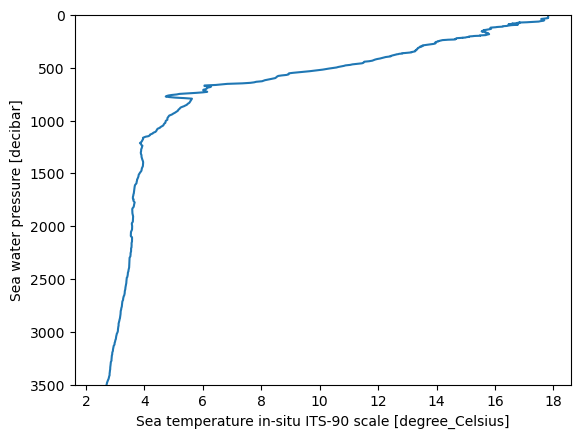

In [15]:
# Você pode plotar um perfil de temperature, por exemplo:
plt.plot(SR6902974['TEMP'][0],SR6902974['PRES'][0])
plt.ylim(3500,0)
plt.xlabel(SR6902974['TEMP'].long_name + ' ['+ SR6902974['TEMP'].units + ']')
plt.ylabel(SR6902974['PRES'].long_name[:18] + ' ['+ SR6902974['PRES'].units + ']')

### Passo 2.1: Plote a salinidade (PSAL) e o oxigênio dissolvido (DOXY). Você percebe algo estranho com esses perfis? Discuta os resultados.

Note que DOXY possui algumas lacunas que aparecem como valores mascarados, então você deve usar um marcador ("." ou "o" ou "-o") para plotá-lo. Veja este https://matplotlib.org/stable/gallery/lines_bars_and_markers/masked_demo.html para alternativas.

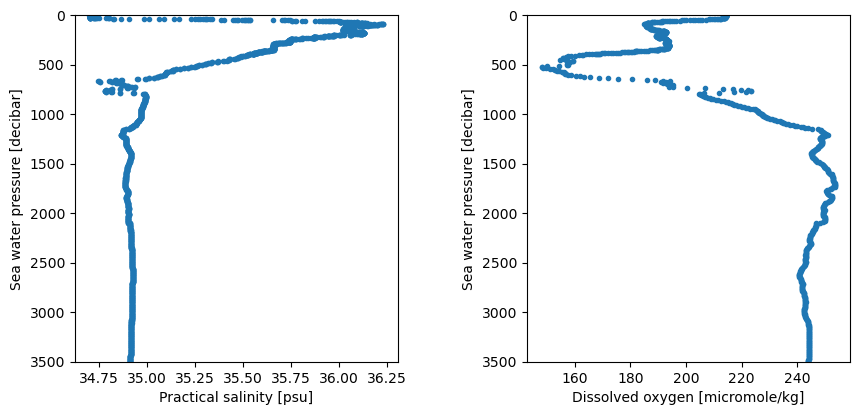

In [17]:
fig = plt.figure(figsize=(10,4.5))

ax1 = fig.add_subplot(121)
plt.plot(SR6902974['PSAL'][0],SR6902974['PRES'][0],'.')
plt.ylim(3500,0)
plt.xlabel(SR6902974['PSAL'].long_name + ' ['+ SR6902974['PSAL'].units + ']')
plt.ylabel(SR6902974['PRES'].long_name[:18] + ' ['+ SR6902974['PRES'].units + ']')

fig.subplots_adjust(wspace=.4)

ax2 = fig.add_subplot(122)
plt.plot(SR6902974['DOXY'][0],SR6902974['PRES'][0],'.-')
plt.ylim(3500,0)
plt.xlabel(SR6902974['DOXY'].long_name + ' ['+ SR6902974['DOXY'].units + ']')
plt.ylabel(SR6902974['PRES'].long_name[:18] + ' ['+ SR6902974['PRES'].units + ']')

# !mkdir img
plt.savefig('img/Salinity_and_Oxygen_Profiles.png',dpi=100)

### Passo 2: Carregando todos os dados

Para evitar confusão nesta prática, vamos colocar as informações mais relevantes em dicionários. Abaixo estão duas funções em python que o César escreveu para esta tarefa.

In [18]:
def jstring(bstring):
    """" Join an array of bstrings into a single string """
    return ''.join(list(map(lambda bstring: bstring.decode('utf-8'), bstring))).strip()

def netCDFtoDict(dataset): 
    """ This function puts the most basic information of an Argo profile
         into a dictionary for simple manipulation. 
         
         Written for an in-class assignment of MARN-5895, UConn.
    
    Input:
    
        - a netCDF Dataset with the Argo profile
        
    Output:
    
        - a dictionary with the profile data, including
        
                - platform (platform number), 
                - longitude (single float number),
                - latitude (single float number),
                - pressure (array of pressure in dbar)
                - temperature (array of temperature in degC)
                - salinity (array of salinity in psu)
                - doxygen (array of dissolved oxygen in micro mole per kg)
         
    """
    
    # mask gaps
    doxy = dataset['DOXY_ADJUSTED'][0].data
    doxy = np.ma.masked_where(doxy==99999.,doxy)
    
    profile_dict = dict(platform=jstring(dataset['PLATFORM_NUMBER'][0].data),
                        longitude=dataset['LONGITUDE'][0].data,
                        latitude=dataset['LATITUDE'][0].data,
                        pressure=dataset['PRES_ADJUSTED'][0].data,
                        temperature=dataset['TEMP_ADJUSTED'][0].data,
                        salinity=dataset['PSAL_ADJUSTED'][0].data,
                        doxygen=doxy,
    )
    
    return profile_dict

In [19]:
# Exemplo de uso da função:
filename = 'SR6902974_045.nc'            
SD6903573 = netCDFtoDict(Dataset(data_dir + filename))

In [65]:
# Agora podemos usar isso para todos os arquivos
# Primeiro, usamos o módulo glob para obter o caminho+nome de todos os arquivos de dados em data_dir
import glob
filenames = glob.glob(data_dir+'/*.nc')
print(filenames)

['tmp/SR6902892_040.nc', 'tmp/SR6903071_007.nc', 'tmp/SR6902981_036.nc', 'tmp/SR6902894_040.nc', 'tmp/SR6902983_011.nc', 'tmp/SR6903085_009.nc', 'tmp/SR6903080_001.nc', 'tmp/SR6902974_045.nc']


In [66]:
#Para obter o número de ID do flutuador, podemos fatiar a string do nome do arquivo, por exemplo, para obter o ID do flutuador do elemento zero de filenames:
filenames[0][:-3]

'tmp/SR6902892_040'

In [78]:
# Colocando tudo junto: percorra os nomes dos arquivos, carregue o conjunto de dados netCDF e coloque as informações básicas em um dicionário
floats = []
for filename in filenames:
    dname = filename[15:-7]
    print('Generating dictionary '+ dname)
    dataset=Dataset(filename)
    exec(dname + ' = netCDFtoDict(dataset)')
    floats.append(dname)

Generating dictionary 


IndentationError: unexpected indent (<string>, line 1)

In [72]:
#  A lista "floats" contém o nome/ID de cada flutuador
# Isso pode ser útil no seu código de plotagem abaixo
floats

['SR6902892',
 'SR6903071',
 'SR6902981',
 'SR6902894',
 'SR6902983',
 'SR6903085',
 'SR6903080',
 'SR6902974']

In [73]:
# O comando "eval" é útil: ele recebe uma string
# como argumento e a transforma em um comando/variável Python
argo_float = eval('SR6902892')
argo_float['temperature']

array([9.324    , 9.324    , 9.3244   , ..., 0.946    , 0.9421935,
       0.942    ], dtype=float32)

(-70.0, 80.0)

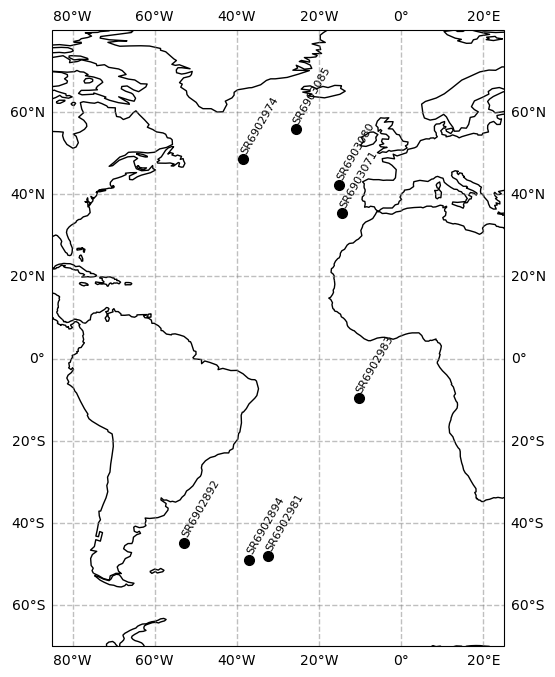

In [75]:
#Esta célula gera um mapa rápido e simples
# com as posições dos flutuadores.
#(Iremos aprender sobre o cartopy em algumas semanas.)

import cartopy.crs as ccrs

# plot quick map with positions
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

for profile in floats:
    
    argo=eval(profile)
    
    ax.plot(argo['longitude'],
            argo['latitude'],
            marker='o',
            markersize=7,
            color='k'
           )
    
    ax.text(argo['longitude']-1.0,
            argo['latitude']+1.5,
            profile,
            color='k',
            rotation=60,
            fontsize=8
           )
    
ax.set_xlim(-85,25)
ax.set_ylim(-70,80)

#### Antes de prosseguir, verifique se os dicionários foram criados.

## Passo 3: Cálculo da temperatura potencial e densidade potencial



3.1 Utilize a função gsw.pt_from_t para calcular a temperatura potencial a partir da temperatura in-situ para cada flutuador. Adicione os perfis de temperatura potencial aos dicionários, nomeando-os como ptemperature.

3.2 Utilize a função gsw.CT_from_pt para calcular a temperatura conservativa a partir da temperatura in-situ para cada flutuador. Adicione os perfis de temperatura conservativa aos dicionários, nomeando-os como ctemperature.

3.3 Utilize a função gsw.sigma0 para calcular a densidade potencial em relação à superfície (0 dbar). Adicione a densidade potencial aos dicionários, nomeando-a como sigma0. (Note que sigma é a densidade potencial menos um valor de referência 1000.)

Notas:

Lembre-se de acessar a ajuda da função usando um ponto de interrogação ?, por exemplo: gsw.sigma0?.
As funções acima requerem como entrada a quantidade de "Salinidade Absoluta" (SA), que em boa aproximação é a mesma que a salinidade calculada a partir da condutividade pelo CTD nos flutuadores Argo. Para os propósitos deste exercício, você pode usar salinity em vez de SA como entrada para as funções acima.





In [173]:
for float_name in floats:
    
    print("Calculating derived fields for " + float_name)
    
    profile = eval(float_name)
    
    # 3.1
    profile['ptemperature'] = gsw.pt_from_t(profile['salinity'],
                                            profile['temperature'],
                                            profile['pressure'],
                                            p_ref=0)
    # 3.2
    profile['ctemperature'] = gsw.CT_from_pt(profile['salinity'],
                                            profile['ptemperature'])

    # 3.3
    profile['sigma0'] = gsw.sigma0(profile['salinity'],
                                   profile['ctemperature'])

Calculating derived fields for SR6902892
Calculating derived fields for SR6902981
Calculating derived fields for SR6903071
Calculating derived fields for SR6902983
Calculating derived fields for SR6902894
Calculating derived fields for SR6902974
Calculating derived fields for SR6903080
Calculating derived fields for SR6903085


### Passo 4: Perfis simples (propriedade vs. pressão)
Crie uma figura com quatro subplots contendo perfis de temperatura potencial (e compare com temperatura in-situ e conservativa), salinidade, densidade potencial e oxigênio dissolvido. Cada subplot deve conter seis perfis, um para cada flutuador. Observe que os perfis de oxigênio têm lacunas, portanto você pode precisar usar um marcador (".", "o" ou "-o") para plotá-lo. Veja https://matplotlib.org/stable/gallery/lines_bars_and_markers/masked_demo.html para alternativas.


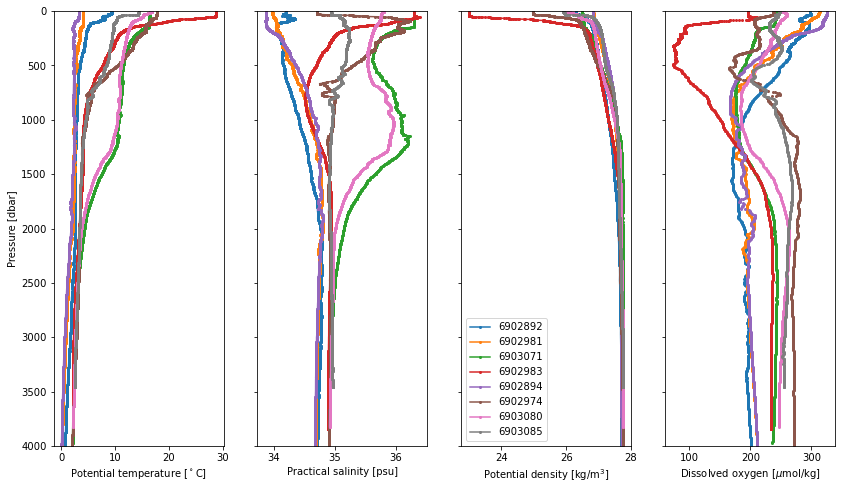

In [139]:
# Subplots 

fig = plt.figure(figsize=(14,8))

kwargs = dict(marker='.',markersize=4)

# First create the axis for the subplots
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

# Now loop over each float and plot each
# property on each axis
for float_name in floats:
        
    profile = eval(float_name)

    ax1.plot(profile['ptemperature'],
             profile['pressure'],
             label=profile['platform'],
             **kwargs
    )
    
    ax2.plot(profile['salinity'],
             profile['pressure'],
             label=profile['platform'],
             **kwargs
    )
    
    ax3.plot(profile['sigma0'],
             profile['pressure'],
             label=profile['platform'],
             **kwargs
    )
 
    
    ax4.plot(profile['doxygen'],
             profile['pressure'],
             label=profile['platform'],
             **kwargs
    )
    
    
# Setting ticks, labels and legend
ax3.legend()

# Setting the y-limits from 4000 to 0
[ax.set_ylim(4000,0) for ax in [ax1,ax2,ax3,ax4]]

yticks = np.arange(0,4500,500)

ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel(r'Potential temperature [$^\circ$C]')
ax1.set_yticks(yticks)

ax2.set_xlabel(r'Practical salinity [psu]')
ax2.set_yticks(yticks)
ax2.set_yticklabels([])

ax3.set_xlabel(r'Potential density [kg/m$^3$]')
ax3.set_yticks(yticks)
ax3.set_yticklabels([])

ax4.set_xlabel(r'Dissolved oxygen [$\mu$mol/kg]')
ax4.set_yticks(yticks)
ax4.set_yticklabels([])

# Saving the figure
fig.savefig('img/Profiles.png',dpi=100)

In [144]:
floats

['SR6902892',
 'SR6902981',
 'SR6903071',
 'SR6902983',
 'SR6902894',
 'SR6902974',
 'SR6903080',
 'SR6903085']

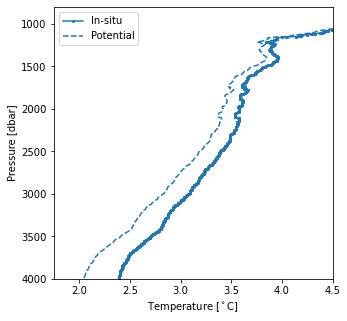

In [182]:
# Comparing potential temperature against in-situ temperature and conservative temperature
# We do this just for a single floats to avoid crowded plots
fig = plt.figure(figsize=(5,5))
        
profile = eval('SR6902974')

p1 = plt.plot(profile['temperature'],
              profile['pressure'],
              label='In-situ',
              **kwargs
)
    
plt.plot(profile['ptemperature'],
         profile['pressure'],
         color=p1[0].get_color(),
         linestyle='--',
         label='Potential'
)    

plt.ylabel('Pressure [dbar]')
plt.xlabel(r'Temperature [$^\circ$C]')
plt.yticks(yticks)
plt.ylim(4000,800)
plt.xlim(1.75,4.5)

plt.legend()

fig.savefig('img/TemperaturesVsPotentialTemperature.png',dpi=100)

### Passo 5: Perfis em função da latitude
Utilize a função plt.scatter para criar uma figura que mostre a dependência latitudinal do oxigênio dissolvido. Escolha um mapa de cores apropriado.

### Passo 6: Gráficos de propriedade-propriedade
4.1 Trace um diagrama theta-S, onde theta representa a temperatura potencial, com todos os seis perfis em um único gráfico. Adicione contornos de densidade ao seu diagrama, semelhante a esta figura.

4.2 Trace temperatura, salinidade e oxigênio dissolvido em função da densidade potencial.

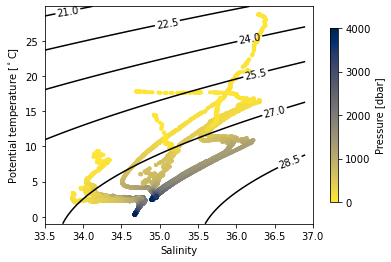

In [169]:
# Adding density contours to TS diagrams

# First, create arrays of T and S
temps = np.arange(-1,30,.1)
sals  = np.arange(33.5,37,.1)

# Second, generate a grid of T and S
Temps, Sals = np.meshgrid(temps,sals)

# Calculate the potential density for each T-S pair
Sigma0 = gsw.sigma0(Sals,Temps)

# Now plot contours
cim = plt.contour(Sals,Temps,Sigma0,colors='k')
ax.clabel(cim, cim.levels, 
          inline=True, fontsize=10)

plt.xlabel('Salinity')
plt.ylabel(r'Potential temperature [$^\circ$C]')

# Now let's plot the data
for float_name in floats:
    
    profile = eval(float_name)
    im = plt.scatter(profile['salinity'], profile['temperature'],
                     c=profile['pressure'], cmap='cividis_r',
                     s=10, vmin=0,vmax=4000,
    )
    
plt.xlim(33.5,37)
plt.colorbar(im,shrink=0.8,
             label='Pressure [dbar]',
             ticks=[0,1000,2000,3000,4000]
)